# Longitudinal Beta Analysis of BSSu Percept recordings

## 0. Loading packages, defining paths

In [1]:
# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz

import seaborn as sns
import pingouin as pg
from itertools import combinations
from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd
import pickle

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 


# TODO: add README file: 
# pip install pingouin
# pip install statannotations
         


Set Path to load PyPerceive

In [2]:
#######################     USE THIS DIRECTORY FOR IMPORTING PYPERCEIVE REPO  #######################

# create a path to the BetaSenSightLongterm folder 
# and a path to the code folder within the BetaSenSightLongterm Repo
BetaSenSightLongterm_path = os.getcwd()
while BetaSenSightLongterm_path[-20:] != 'BetaSenSightLongterm':
    BetaSenSightLongterm_path = os.path.dirname(BetaSenSightLongterm_path)

# directory to PyPerceive code folder
PyPerceive_path = os.path.join(BetaSenSightLongterm_path, 'code', 'PyPerceive', 'code')
sys.path.append(PyPerceive_path)

# # change directory to PyPerceive code path within BetaSenSightLongterm Repo
os.chdir(PyPerceive_path)
os.getcwd()

'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code\\PyPerceive\\code'

Load PyPerceive

In [3]:
from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers


importlib.reload(main_class)
importlib.reload(session_class)
importlib.reload(task_class)
importlib.reload(condition_class)
importlib.reload(contact_class)
importlib.reload(metadata_class)
importlib.reload(modality_class)
importlib.reload(load_rawfile)
importlib.reload(find_folders)
importlib.reload(run_class)
importlib.reload(metaHelpers)

<module 'PerceiveImport.methods.metadata_helpers' from 'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code\\PyPerceive\\code\\PerceiveImport\\methods\\metadata_helpers.py'>

Set Path back to BetaSenSightLongterm Repo

In [4]:
#######################     USE THIS DIRECTORY FOR WORKING WITH FOLDERS INSIDE OF CODE FOLDER OF BETASENSIGHTLONGTERM REPO  #######################


# create a path to the BetaSenSightLongterm folder 
# and a path to the code folder within the BetaSenSightLongterm Repo
BetaSenSightLongterm_path = os.getcwd()
while BetaSenSightLongterm_path[-20:] != 'BetaSenSightLongterm':
    BetaSenSightLongterm_path = os.path.dirname(BetaSenSightLongterm_path)

# directory to code folder
code_path = os.path.join(BetaSenSightLongterm_path, "code")
sys.path.append(code_path)

# # change directory to code path within BetaSenSightLongterm Repo
os.chdir(code_path)
os.getcwd()

'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code'

Load analysis functions

In [148]:
import analysis.utils.BSSuPsd as BSSuPsd
import analysis.utils.FastFourierPSD as FFpsd
import analysis.utils.MonoRef_JLB as MonoRefJLB
import analysis.utils.loadResults as loadResults
import analysis.utils.find_folders as find_folders
import analysis.utils.HighestRankedChannelPSD as highestRank
import analysis.utils.GroupMonopolarPSD as groupMonopol
import analysis.utils.PSDaverage_Comparisons as comparisonPSD

# import Classes
from analysis.classes import (metadataAnalysis_class, mainAnalysis_class, sessionAnalysis_class, 
                              channelAnalysis_class, featureAnalysis_class, frequencyBand_class)



importlib.reload(BSSuPsd)
importlib.reload(MonoRefJLB)
importlib.reload(loadResults)
importlib.reload(highestRank)
importlib.reload(groupMonopol)
importlib.reload(comparisonPSD)
importlib.reload(FFpsd)
importlib.reload(find_folders)
importlib.reload(metadataAnalysis_class)
importlib.reload(mainAnalysis_class)
importlib.reload(sessionAnalysis_class)
importlib.reload(channelAnalysis_class)
importlib.reload(featureAnalysis_class)
importlib.reload(frequencyBand_class)

<module 'analysis.classes.frequencyBand_class' from 'c:\\Users\\jebe12\\Research\\Longterm_beta_project\\Code\\BetaSenSightLongterm\\code\\analysis\\classes\\frequencyBand_class.py'>

## 1. Calculate PSD averages of Beta, High Beta and Low Beta


	### WARNING: NaNs in Metadata Table sub-029 ###
NaNs in: sub029_ses-2021121307400597_run-BrainSense20211213081800.mat
NaNs in: sub029_ses-2021121307400597_run-BrainSense20211213085200.mat
NaNs in: sub029_ses-2021121307400597_run-BrainSense20211213091300.mat
NaNs in: sub029_ses-2021121307400597_run-BrainSense20211213093000.mat
NaNs in: sub029_ses-2021121307400597_run-BrainSense20211213094800.mat
NaNs in: sub029_ses-2021121310283697_run-BrainSense20211213103800.mat
NaNs in: sub029_ses-2021121310283697_run-BrainSense20211213105100.mat
NaNs in: sub029_ses-2021121310283697_run-BrainSense20211213111500.mat
NaNs in: sub029_ses-2021121310283697_run-BrainSense20211213113400.mat
NaNs in: sub029_ses-2021121310283697_run-BrainSense20211213115400.mat
NaNs in: sub-20210924PStn_ses-2021092907581699_run-BrainSense20210929080700.mat
NaNs in: sub-20210924PStn_ses-2021092907581699_run-BrainSense20210929081000.mat
NaNs in: sub-20210924PStn_ses-2021092907581699_run-BrainSense20210929081300.mat
NaNs in: s

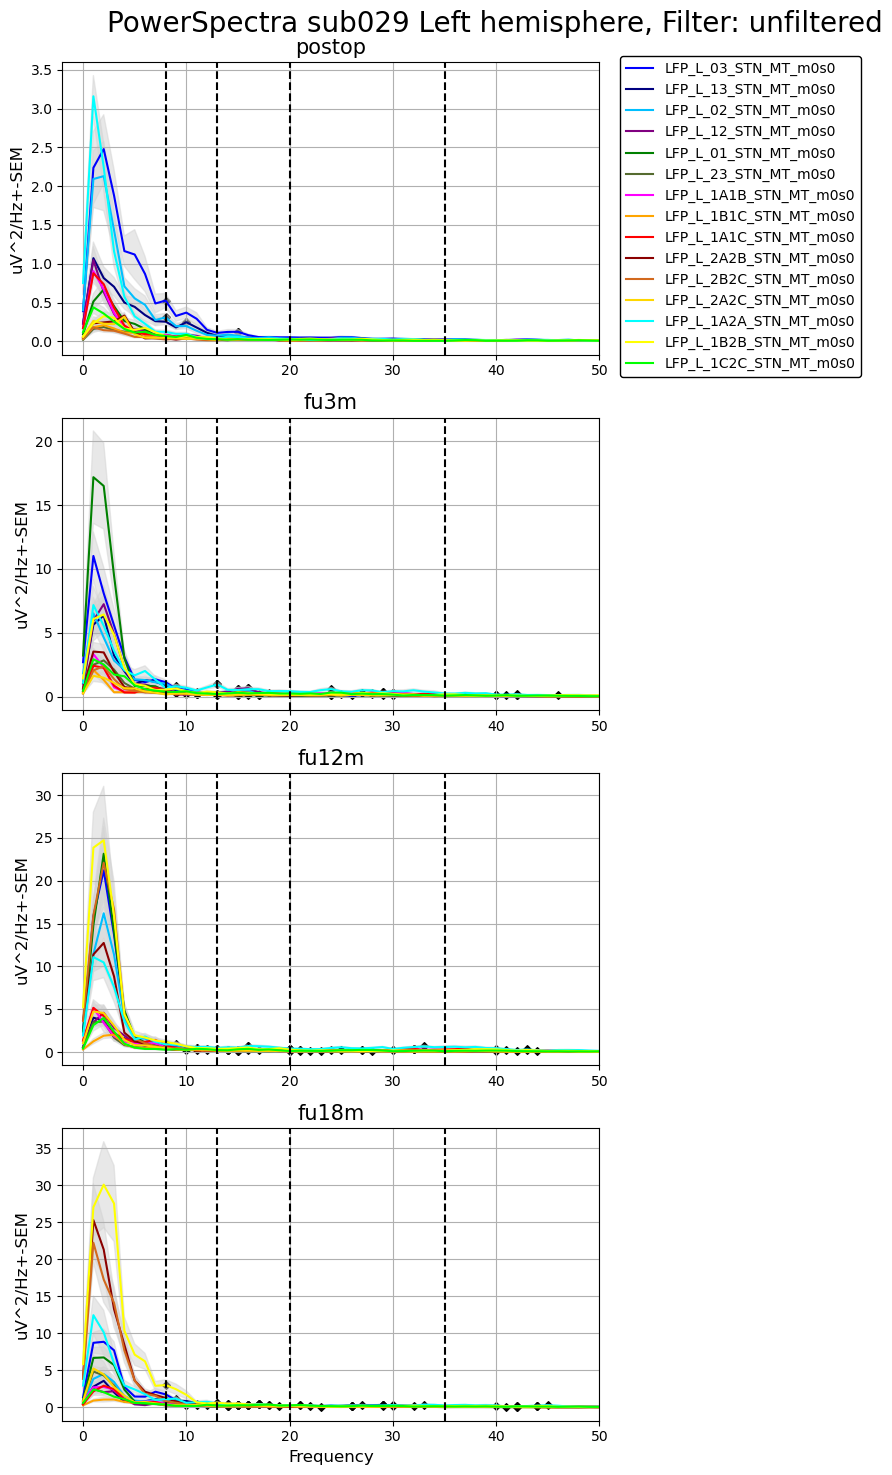

no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied


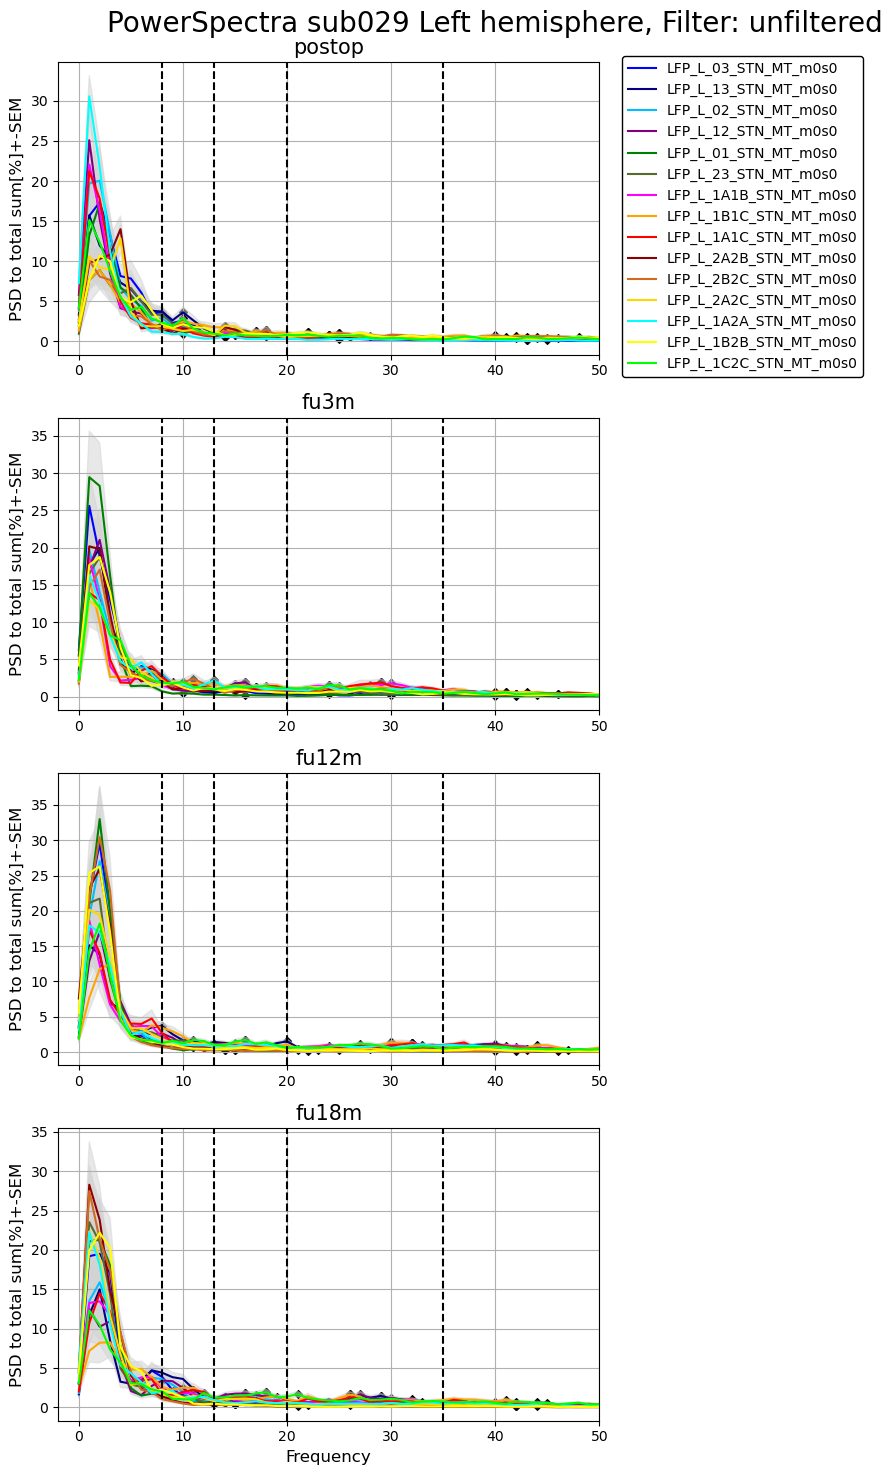

no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied


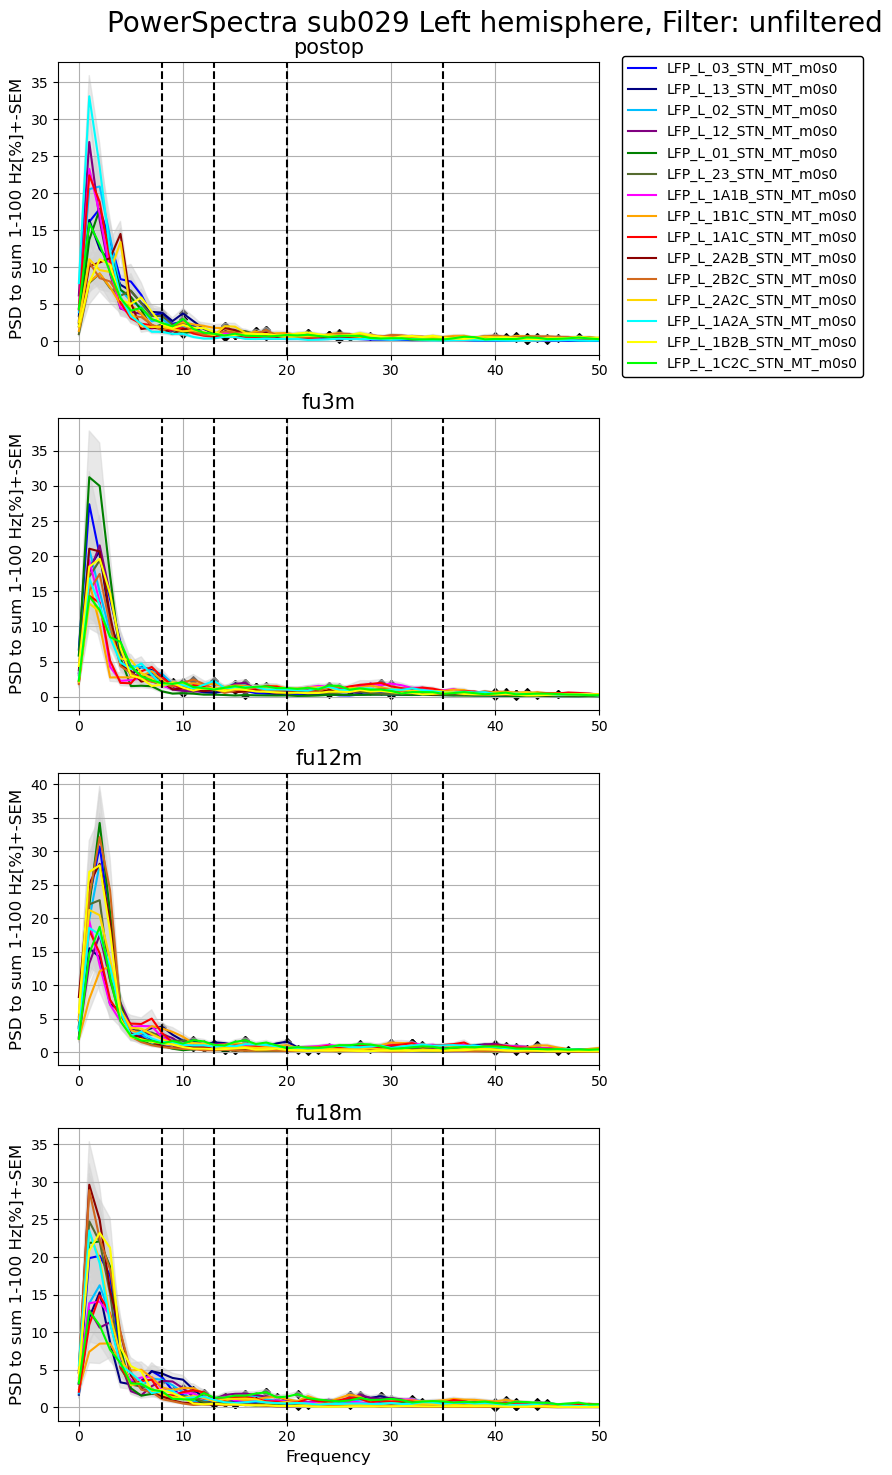

no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied
no filter applied


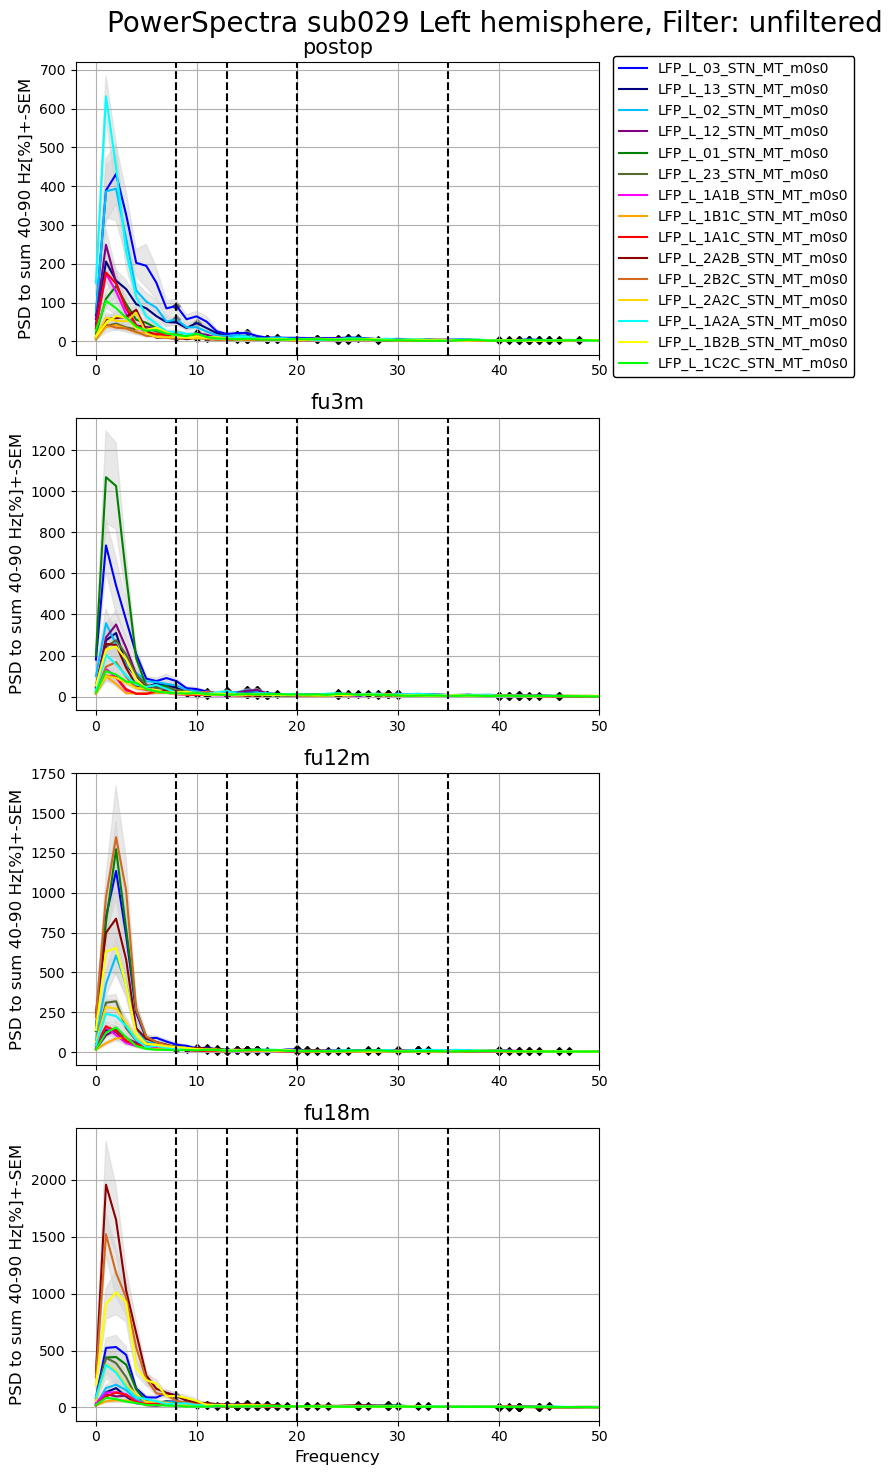

In [137]:
FF_psd_sub024 = FFpsd.spectrogram_Psd(
    incl_sub = "029", 
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    incl_condition = ["m0s0"],
    pickChannels=['03', '13', '02', '12', '01', '23',
                  '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C',
                  '1A2A', '1B2B', '1C2C'],
    hemisphere="Left",
    filter = "unfiltered")

In [95]:
FF_psd_sub024["averagedPSD_unfiltered"]

,session,bipolarChannel,frequencyBand,absoluteOrRelativePSD,averagedPSD
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_alpha,postop,LFP_R_03_STN_MT,alpha,rawPsd,0.223263
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_lowBeta,postop,LFP_R_03_STN_MT,lowBeta,rawPsd,0.079083
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_highBeta,postop,LFP_R_03_STN_MT,highBeta,rawPsd,0.040406
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_beta,postop,LFP_R_03_STN_MT,beta,rawPsd,0.053859
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_narrowGamma,postop,LFP_R_03_STN_MT,narrowGamma,rawPsd,0.01173
...,...,...,...,...,...
fu18m_LFP_R_1C2C_STN_MT_psdAverage_normPsdToSum40_90Hz_alpha,fu18m,LFP_R_1C2C_STN_MT,alpha,normPsdToSum40_90Hz,21.325513
fu18m_LFP_R_1C2C_STN_MT_psdAverage_normPsdToSum40_90Hz_lowBeta,fu18m,LFP_R_1C2C_STN_MT,lowBeta,normPsdToSum40_90Hz,12.79742
fu18m_LFP_R_1C2C_STN_MT_psdAverage_normPsdToSum40_90Hz_highBeta,fu18m,LFP_R_1C2C_STN_MT,highBeta,normPsdToSum40_90Hz,10.636081
fu18m_LFP_R_1C2C_STN_MT_psdAverage_normPsdToSum40_90Hz_beta,fu18m,LFP_R_1C2C_STN_MT,beta,normPsdToSum40_90Hz,11.387851


In [108]:
path = find_folders.get_local_path(folder="GroupResults")

In [55]:
dictionary = {"key": "value"}
dictionary["key"]

'value'

In [31]:
filepath = os.path.join("c:\\Users\\jebe12\\Research\\Longterm_beta_project\\results", "pickleFile")

# "wb" write bytes: pickle files can not be opened visually, it can only be opened by code
# pickle will save the output code as it is, so Dataframes can be saved just as they are

with open(filepath, "wb") as file: 
    pickle.dump(averagePSD_DF, file)

In [32]:
with open(filepath, "rb") as file:
    new_tfr = pickle.load(file)

In [100]:
data = loadcsv.load_PSDjson(
    sub="029",
    psdMethod = "Spectrogram",
    hemisphere="Left",
    filter = "band-pass"
    
)

In [101]:
data.keys()

dict_keys(['session', 'bipolarChannel', 'frequency', 'time_sectors', 'averagedPSD', 'SEM_rawPsd', 'normPsdToTotalSum', 'SEM_normPsdToTotalSum', 'normPsdToSumPsd1to100Hz', 'SEM_normPsdToSumPsd1to100Hz', 'normPsdToSum40to90Hz', 'SEM_normPsdToSum40to90Hz'])

## 2. Load the PSD Data from results

In [117]:
PSD_data = loadResults.load_PSDjson(
    sub="029",
    result = "PSDaverageFrequencyBands",
    normalization="rawPSD",
    hemisphere="Right",
    filter = "band-pass")

In [119]:
pd.DataFrame(PSD_data).head()

,session,bipolarChannel,frequencyBand,averagedrawPSD
postop_LFP_R_03_STN_MT_psdAverage_alpha,postop,LFP_R_03_STN_MT,alpha,0.222092
postop_LFP_R_03_STN_MT_psdAverage_lowBeta,postop,LFP_R_03_STN_MT,lowBeta,0.079082
postop_LFP_R_03_STN_MT_psdAverage_highBeta,postop,LFP_R_03_STN_MT,highBeta,0.040406
postop_LFP_R_03_STN_MT_psdAverage_beta,postop,LFP_R_03_STN_MT,beta,0.053858
postop_LFP_R_03_STN_MT_psdAverage_narrowGamma,postop,LFP_R_03_STN_MT,narrowGamma,0.011582


In [8]:
PSD_data.head()

,Unnamed: 0,session,bipolarChannel,frequency,time_sectors,averagedPSD,SEM_rawPsd
0,postop_LFP_R_03_STN_MT,postop,LFP_R_03_STN_MT,[ 0. 1. 2. 3. 4. 5. 6. 7. 8. ...,[ 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...,[1.98748242e-03 8.77175156e-04 2.23155273e-05 ...,[5.49105589e-04 2.40398269e-04 3.51229545e-06 ...
1,postop_LFP_R_13_STN_MT,postop,LFP_R_13_STN_MT,[ 0. 1. 2. 3. 4. 5. 6. 7. 8. ...,[ 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...,[8.87520108e-04 3.86220607e-04 8.80750641e-06 ...,[2.30384146e-04 1.00100378e-04 1.47232110e-06 ...
2,postop_LFP_R_02_STN_MT,postop,LFP_R_02_STN_MT,[ 0. 1. 2. 3. 4. 5. 6. 7. 8. ...,[ 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...,[6.97628621e-04 3.06070804e-04 1.23665092e-05 ...,[1.81961362e-04 7.87826741e-05 1.98134298e-06 ...
3,postop_LFP_R_12_STN_MT,postop,LFP_R_12_STN_MT,[ 0. 1. 2. 3. 4. 5. 6. 7. 8. ...,[ 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...,[3.93950597e-04 1.73072352e-04 3.45673650e-06 ...,[9.20544259e-05 4.04224129e-05 5.07386414e-07 ...
4,postop_LFP_R_01_STN_MT,postop,LFP_R_01_STN_MT,[ 0. 1. 2. 3. 4. 5. 6. 7. 8. ...,[ 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...,[2.51056101e-04 1.13693961e-04 5.29367263e-06 ...,[7.41735398e-05 3.31311134e-05 1.02013022e-06 ...


In [21]:
type(PSD_data.loc[0, "frequency"])

str

In [14]:
PSDFreqBands_data = loadcsv.load_freqBandsCSV(
    sub="029",
    parameters="PSDaverage",
    normalization="rawPSD",
    hemisphere="Right",
    filter = "band-pass")

In [15]:
PSDFreqBands_data.head()

,Unnamed: 0,session,bipolarChannel,frequencyBand,averagedrawPSD
0,postop_LFP_R_03_STN_MT_psdAverage_alpha,postop,LFP_R_03_STN_MT,alpha,0.222092
1,postop_LFP_R_03_STN_MT_psdAverage_lowBeta,postop,LFP_R_03_STN_MT,lowBeta,0.079082
2,postop_LFP_R_03_STN_MT_psdAverage_highBeta,postop,LFP_R_03_STN_MT,highBeta,0.040406
3,postop_LFP_R_03_STN_MT_psdAverage_beta,postop,LFP_R_03_STN_MT,beta,0.053858
4,postop_LFP_R_03_STN_MT_psdAverage_narrowGamma,postop,LFP_R_03_STN_MT,narrowGamma,0.011582


Create three groups: Ring, SegmInter, SegmIntra
- 1. for each group plot the PSD average of each channel over time (x=session, y=PSD average), average PSD over channels within a group (+- standard deviation)
- 2. each group is a column, plot one channel per Row, within one subplot: Power spectrum of one channel at different timepoints

In [9]:
# group Dataframe into Ring, Segments Intra, Segments Inter

Ring = ['LFP_R_03_STN_MT', 'LFP_R_13_STN_MT', 'LFP_R_02_STN_MT', 'LFP_R_12_STN_MT', 'LFP_R_01_STN_MT', 'LFP_R_23_STN_MT']
SegmIntra = ['LFP_R_1A1B_STN_MT', 'LFP_R_1B1C_STN_MT', 'LFP_R_1A1C_STN_MT', 'LFP_R_2A2B_STN_MT', 'LFP_R_2B2C_STN_MT', 'LFP_R_2A2C_STN_MT']
SegmInter = ['LFP_R_1A2A_STN_MT', 'LFP_R_1B2B_STN_MT', 'LFP_R_1C2C_STN_MT']


# make new DF for each group containing only Channels within each group
Ring_DF = PSD_data[PSD_data.bipolarChannel.isin(Ring)]
SegmIntra_DF = PSD_data[PSD_data.bipolarChannel.isin(SegmIntra)]
SegmInter_DF = PSD_data[PSD_data.bipolarChannel.isin(SegmInter)]

In [10]:
from ast import literal_eval

In [11]:
# plot within one subplot: one channel with 3 different timepoints

timepoints = ["postop", "fu3m", "fu12m", "fu18m"]

# get DF only of one channel
Channel_03_DF = Ring_DF[Ring_DF.bipolarChannel.str.contains("03")]
Channel_03_DF.reset_index(inplace=True) # reset index to 0
Channel_03_DF.frequency.apply(literal_eval) # literal_eval transforms the array stored in string back to an array
Channel_03_DF.averagedPSD.apply(literal_eval)

# plot one channel within the same subplot 
plt.subplot(3,6,1)

# loop over each timepoint and plot raw PSD
for tp, session in enumerate(timepoints):
    
    session_DF = Channel_03_DF[Channel_03_DF.session == session]
    f = session_DF.loc[0, "frequency"] # commas missing between values!
    

    psd = session_DF.loc[0, "averagedPSD"]
    
    plt.plot(f, psd, label= f"{session}")


plt.show()



SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

In [13]:
f = Channel_03_DF.loc[0, "frequency"]
f = f.replace("  ", ",").replace(".\n", ",")
f
#Channel_03_DF.frequency.apply(literal_eval)



'[,0., 1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,12.,13,,14.,15.,16.,17.,18.,19.,20.,21.,22.,23.,24.,25.,26.,27,,28.,29.,30.,31.,32.,33.,34.,35.,36.,37.,38.,39.,40.,41,,42.,43.,44.,45.,46.,47.,48.,49.,50.,51.,52.,53.,54.,55,,56.,57.,58.,59.,60.,61.,62.,63.,64.,65.,66.,67.,68.,69,,70.,71.,72.,73.,74.,75.,76.,77.,78.,79.,80.,81.,82.,83,,84.,85.,86.,87.,88.,89.,90.,91.,92.,93.,94.,95.,96.,97,,98.,99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111, 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.]'

<AxesSubplot:>

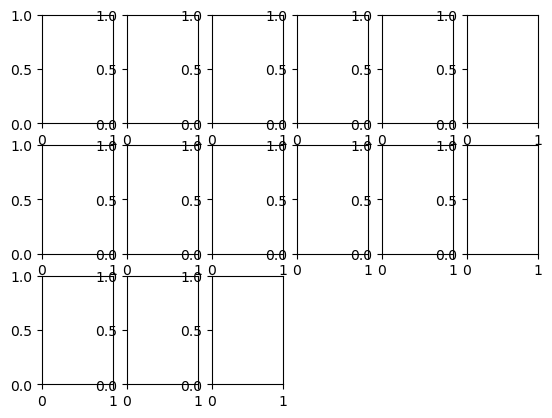

In [51]:
# figure layout

# RING: 6 Channels row1
plt.subplot(3, 6, 1) # row 1, column 2, count 1
plt.subplot(3, 6, 2) # row 1, column 2, count 1
plt.subplot(3, 6, 3) # row 1, column 2, count 1
plt.subplot(3, 6, 4) # row 1, column 2, count 1
plt.subplot(3, 6, 5) # row 1, column 2, count 1
plt.subplot(3, 6, 6) # row 1, column 2, count 1

# SegmIntra: 6 Channels row2
plt.subplot(3, 6, 7) # row 1, column 2, count 1
plt.subplot(3, 6, 8) # row 1, column 2, count 1
plt.subplot(3, 6, 9) # row 1, column 2, count 1
plt.subplot(3, 6, 10) # row 1, column 2, count 1
plt.subplot(3, 6, 11) # row 1, column 2, count 1
plt.subplot(3, 6, 12) # row 1, column 2, count 1

# SegmInter: 3 Channels row3
plt.subplot(3, 6, 13) # row 1, column 2, count 1
plt.subplot(3, 6, 14) # row 1, column 2, count 1
plt.subplot(3, 6, 15) # row 1, column 2, count 1

## Load Results with Classes

In [149]:
data = mainAnalysis_class.MainClass(
    sub="029",
    hemisphere = "Right",
    filter = "band-pass",
    result = "PSDaverageFrequencyBands",
    incl_session = ["postop", "fu3m", "fu12m", "fu18m"],
    pickChannels = ['03', '13', '02', '12', '01', '23', 
                    '1A1B', '1B1C', '1A1C', '2A2B', '2B2C', '2A2C', 
                    '1A2A', '1B2B', '1C2C'],
    normalization = ["rawPsd", "normPsdToSum1_100Hz"],
    freqBands = ["beta", "highBeta", "lowBeta"],
    feature= ["averagedPSD"]
    
)

Freq Band from Channel Class:                                               session   bipolarChannel  \
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_beta  postop  LFP_R_03_STN_MT   

                                              frequencyBand  \
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_beta          beta   

                                              absoluteOrRelativePSD  \
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_beta                rawPsd   

                                               averagedPSD  
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_beta     0.053858  
Freq Band from Channel Class:                                                   session   bipolarChannel  \
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_highBeta  postop  LFP_R_03_STN_MT   

                                                  frequencyBand  \
postop_LFP_R_03_STN_MT_psdAverage_rawPsd_highBeta      highBeta   

                                                  absoluteOrRelativePSD  \
postop_LFP_R_03_STN_MT_psdAverag

In [150]:
data.postop.BIP_03.normPsdToSum1_100Hz.beta.averagedPSD.data

1.4643199383